In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from typing import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /Users/ardan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ardan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/ardan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Data Gathering

In [3]:
df = pd.read_csv('final_perfume_data.csv', encoding = 'unicode_escape')
df.head()

,Name,Brand,Description,Notes,Image URL
0,Tihota Eau de Parfum,Indult,"Rapa Nui for sugar, Tihota is, quite simply, ...","Vanilla bean, musks",https://static.luckyscent.com/images/products/...
1,Sola Parfum,Di Ser,A tribute to the expanse of space extending f...,"Lavender, Yuzu, Lemongrass, Magnolia, Geraniu...",https://static.luckyscent.com/images/products/...
2,Kagiroi Parfum,Di Ser,An aromatic ode to the ancient beauty of Japa...,"Green yuzu, green shikuwasa, sansho seed, cor...",https://static.luckyscent.com/images/products/...
3,Velvet Fantasy Eau de Parfum,Montale,Velvet Fantasy is a solar fragrance where cit...,"tangerine, pink pepper, black coffee, leat...",https://static.luckyscent.com/images/products/...
4,A Blvd. Called Sunset Eau de Parfum,A Lab on Fire,There's no way A Lab On Fire could relocate t...,"Bergamot, almond, violet, jasmine, leather, s...",https://static.luckyscent.com/images/products/...


In [32]:
(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         2191 non-null   object
 1   Brand        2191 non-null   object
 2   Description  2191 non-null   object
 3   Notes        2111 non-null   object
 4   Image URL    2191 non-null   object
 5   Notes_Count  2191 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 102.8+ KB


# Data Understanding

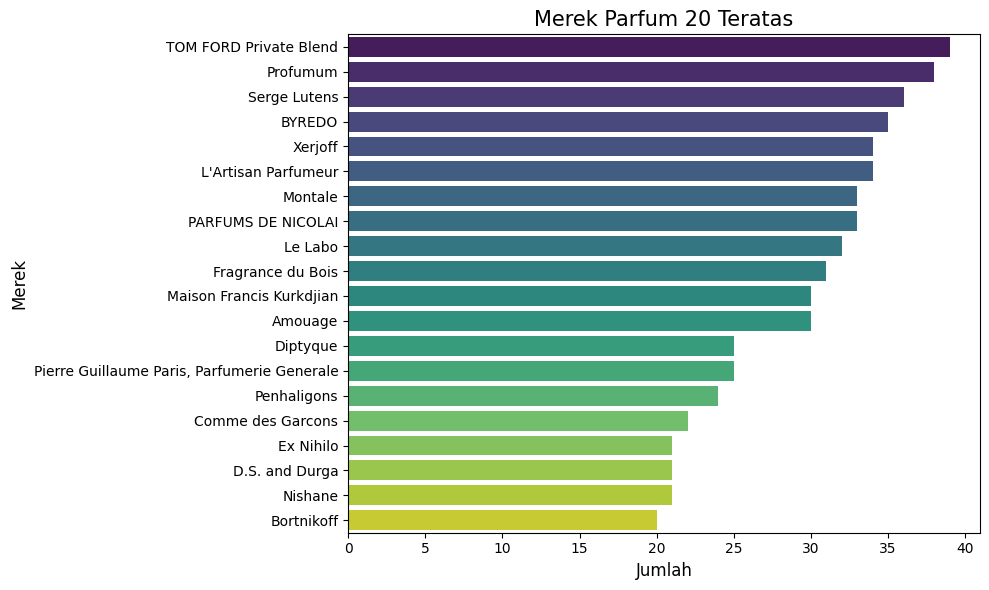

Persentase parfum dari 20 merek teratas: 26.65%


In [5]:
# Menampilkan distribusi merek parfum teratas
plt.figure(figsize=(10, 6))
brand_counts = df['Brand'].value_counts().head(20)
sns.barplot(x=brand_counts.values, y=brand_counts.index, hue=brand_counts.index, palette='viridis', legend=False)
plt.title('Merek Parfum 20 Teratas', fontsize=15)
plt.xlabel('Jumlah', fontsize=12)
plt.ylabel('Merek', fontsize=12)
plt.tight_layout()
plt.show()

# Menghitung persentase dari total untuk brand terpopuler
top_brands_percentage = (brand_counts.sum() / len(df)) * 100
print(f"Persentase parfum dari 20 merek teratas: {top_brands_percentage:.2f}%")

In [6]:
print("Brand parfum terpopuler:")
print(brand_counts.head(10))

Brand parfum terpopuler:
Brand
TOM FORD Private Blend    39
Profumum                  38
Serge Lutens              36
BYREDO                    35
Xerjoff                   34
L'Artisan Parfumeur       34
Montale                   33
PARFUMS DE NICOLAI        33
Le Labo                   32
Fragrance du Bois         31
Name: count, dtype: int64


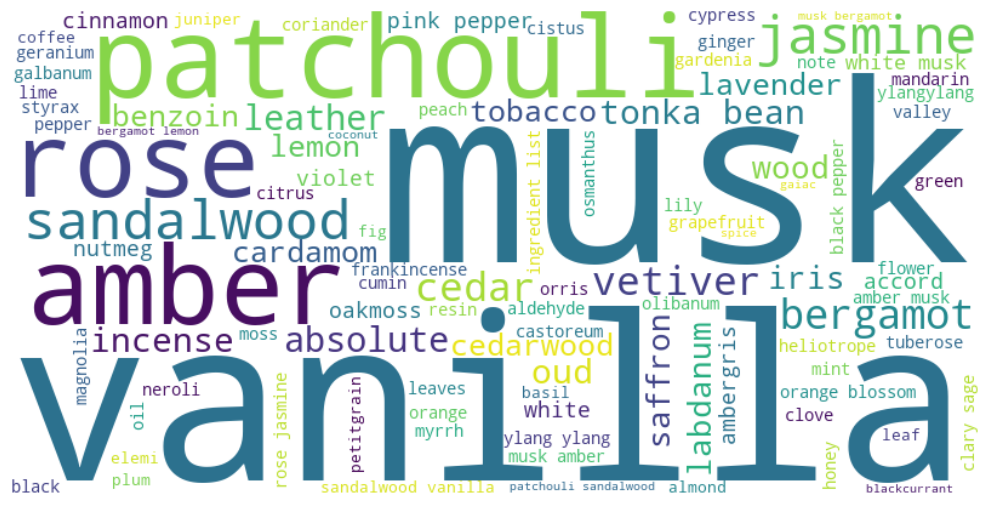

In [7]:
# Get all notes as a single string
all_notes = ', '.join(df['Notes'].dropna().astype(str))

# Clean and tokenize
all_notes = re.sub(r'[^\w\s,]', '', all_notes.lower())
all_notes_list = [note.strip() for note in all_notes.split(',')]

# Buat wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_notes)

# Tampilkan wordcloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# Plot the most common notes overall
notes_counter = Counter(all_notes_list)

all_notes_freq = notes_counter.most_common(15)
all_notes_df = pd.DataFrame(all_notes_freq, columns=['Note', 'Frequency'])

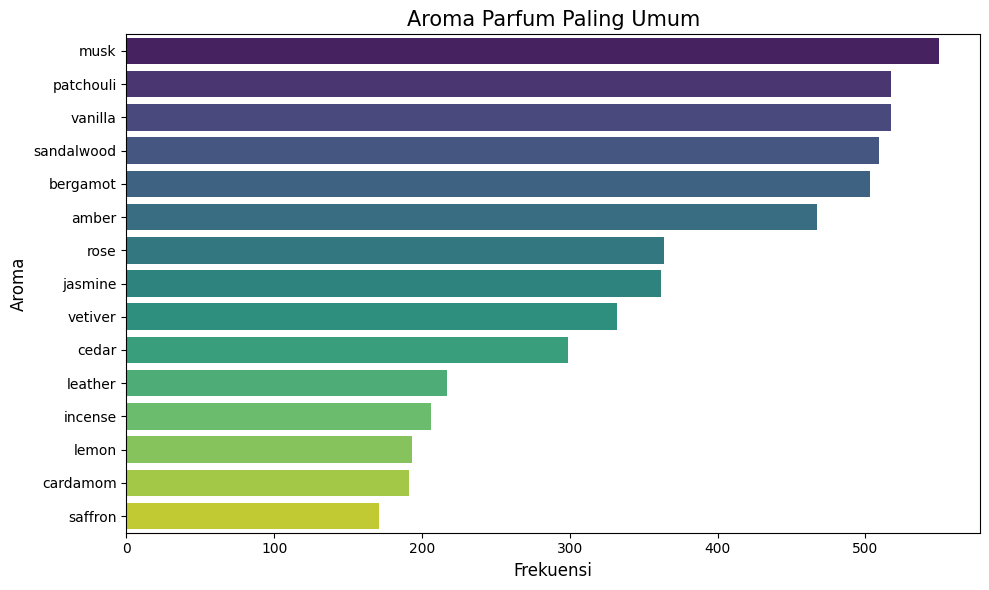

In [9]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Note', hue='Note', data=all_notes_df, palette='viridis', legend=False)
plt.title('Aroma Parfum Paling Umum', fontsize=15)
plt.xlabel('Frekuensi', fontsize=12)
plt.ylabel('Aroma', fontsize=12)
plt.tight_layout()
plt.show()

In [10]:
print("Aroma yang paling umum:")
for note, freq in all_notes_freq:
    print(f"{note}: {freq}")

Aroma yang paling umum:
musk: 550
patchouli: 517
vanilla: 517
sandalwood: 509
bergamot: 503
amber: 467
rose: 364
jasmine: 362
vetiver: 332
cedar: 299
leather: 217
incense: 206
lemon: 193
cardamom: 191
saffron: 171


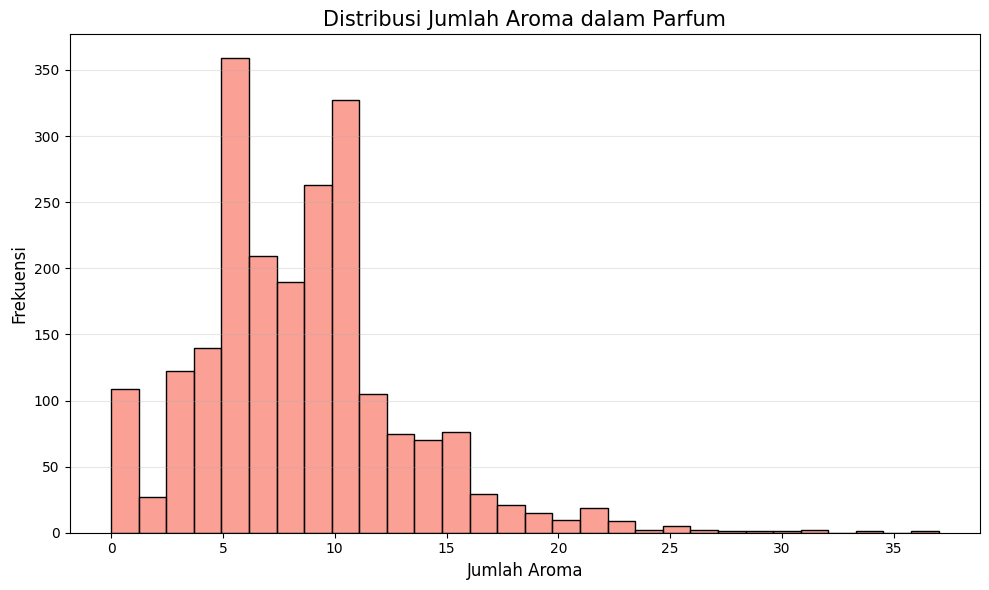

Statistik Deskriptif untuk Jumlah Aroma:
count    2191.000000
mean        8.465084
std         4.632675
min         0.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        37.000000
Name: Notes_Count, dtype: float64

Parfum dengan nol aroma: 80 (3.65%)
Parfum dengan lebih dari 15 aroma: 159 (7.26%)
Median jumlah aroma per parfum: 8.0


In [11]:
# Hitung jumlah notes
df['Notes_Count'] = df['Notes'].apply(lambda x: len(str(x).split(',')) if not pd.isna(x) else 0)

# Visualisasi distribusi jumlah notes
plt.figure(figsize=(10, 6))
sns.histplot(df['Notes_Count'], bins=30, color='salmon')
plt.title('Distribusi Jumlah Aroma dalam Parfum', fontsize=15)
plt.xlabel('Jumlah Aroma', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Statistik deskriptif untuk jumlah aroma
notes_stats = df['Notes_Count'].describe()
print("Statistik Deskriptif untuk Jumlah Aroma:")
print(notes_stats)

# Tambahan analisis untuk aroma count
print(f"\nParfum dengan nol aroma: {(df['Notes_Count'] == 0).sum()} ({(df['Notes_Count'] == 0).sum()/len(df)*100:.2f}%)")
print(f"Parfum dengan lebih dari 15 aroma: {(df['Notes_Count'] > 15).sum()} ({(df['Notes_Count'] > 15).sum()/len(df)*100:.2f}%)")
print(f"Median jumlah aroma per parfum: {df['Notes_Count'].median()}")


# Data Preparation

In [12]:
missing_values = df.isna().sum()
print("Missing Values per Kolom:")
print(missing_values)
print(f"\nPersentase missing values pada kolom Notes: {missing_values['Notes']/len(df)*100:.2f}%")

Missing Values per Kolom:
Name            0
Brand           0
Description     0
Notes          80
Image URL       0
Notes_Count     0
dtype: int64

Persentase missing values pada kolom Notes: 3.65%


In [13]:
df_clean = df.dropna(subset=['Notes']).copy()

In [14]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2111 entries, 0 to 2190
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         2111 non-null   object
 1   Brand        2111 non-null   object
 2   Description  2111 non-null   object
 3   Notes        2111 non-null   object
 4   Image URL    2111 non-null   object
 5   Notes_Count  2111 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 115.4+ KB


In [15]:
# Fungsi untuk membersihkan dan menormalisasi teks
def normalize_text(text):
    if pd.isna(text):
        return text
    
    # Konversi ke lowercase
    text = text.lower()
    
    # Hapus karakter khusus dan angka
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Hapus whitespace berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [16]:
# Terapkan normalisasi ke kolom Description dan Notes menggunakan .loc
df_clean.loc[:, 'Notes_Normalized'] = df_clean['Notes'].apply(normalize_text)

# Contoh hasil normalisasi
print("Sebelum normalisasi:")
print(df_clean['Notes'].iloc[0])
print("\nSetelah normalisasi:")
print(df_clean['Notes_Normalized'].iloc[0])

Sebelum normalisasi:
 Vanilla bean, musks

Setelah normalisasi:
vanilla bean musks


In [17]:
# Fungsi untuk tokenisasi
def tokenize(text):
    if pd.isna(text):
        return []
    
    # Tokenisasi menggunakan NLTK
    tokens = word_tokenize(text)
    
    return tokens

In [18]:
# Terapkan tokenisasi dan stopword removal
df_clean.loc[:, 'Notes_Tokens'] = df_clean['Notes_Normalized'].apply(tokenize)

# Gabungkan tokens menjadi teks bersih
df_clean.loc[:, 'Notes_Clean'] = df_clean['Notes_Tokens'].apply(lambda x: ' '.join(x))

# Contoh hasil tokenisasi dan pembersihan
print("Hasil tokenisasi dan pembersihan catatan parfum pertama:")
print(df_clean['Notes_Clean'].iloc[0][:20])  # Tampilkan 20 token pertama

Hasil tokenisasi dan pembersihan catatan parfum pertama:
vanilla bean musks


In [19]:
df_clean.head()

,Name,Brand,Description,Notes,Image URL,Notes_Count,Notes_Normalized,Notes_Tokens,Notes_Clean
0,Tihota Eau de Parfum,Indult,"Rapa Nui for sugar, Tihota is, quite simply, ...","Vanilla bean, musks",https://static.luckyscent.com/images/products/...,2,vanilla bean musks,"[vanilla, bean, musks]",vanilla bean musks
1,Sola Parfum,Di Ser,A tribute to the expanse of space extending f...,"Lavender, Yuzu, Lemongrass, Magnolia, Geraniu...",https://static.luckyscent.com/images/products/...,8,lavender yuzu lemongrass magnolia geranium jas...,"[lavender, yuzu, lemongrass, magnolia, geraniu...",lavender yuzu lemongrass magnolia geranium jas...
2,Kagiroi Parfum,Di Ser,An aromatic ode to the ancient beauty of Japa...,"Green yuzu, green shikuwasa, sansho seed, cor...",https://static.luckyscent.com/images/products/...,12,green yuzu green shikuwasa sansho seed coriand...,"[green, yuzu, green, shikuwasa, sansho, seed, ...",green yuzu green shikuwasa sansho seed coriand...
3,Velvet Fantasy Eau de Parfum,Montale,Velvet Fantasy is a solar fragrance where cit...,"tangerine, pink pepper, black coffee, leat...",https://static.luckyscent.com/images/products/...,14,tangerine pink pepper black coffee leather vio...,"[tangerine, pink, pepper, black, coffee, leath...",tangerine pink pepper black coffee leather vio...
4,A Blvd. Called Sunset Eau de Parfum,A Lab on Fire,There's no way A Lab On Fire could relocate t...,"Bergamot, almond, violet, jasmine, leather, s...",https://static.luckyscent.com/images/products/...,8,bergamot almond violet jasmine leather sandalw...,"[bergamot, almond, violet, jasmine, leather, s...",bergamot almond violet jasmine leather sandalw...


In [20]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2111 entries, 0 to 2190
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              2111 non-null   object
 1   Brand             2111 non-null   object
 2   Description       2111 non-null   object
 3   Notes             2111 non-null   object
 4   Image URL         2111 non-null   object
 5   Notes_Count       2111 non-null   int64 
 6   Notes_Normalized  2111 non-null   object
 7   Notes_Tokens      2111 non-null   object
 8   Notes_Clean       2111 non-null   object
dtypes: int64(1), object(8)
memory usage: 164.9+ KB


# Modeling

In [21]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
  min_df=2,
  max_df=0.9,
  max_features=1000,
  ngram_range=(1, 2)
  )
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['Notes_Clean'])

In [22]:
print(tfidf_matrix.shape)

(2111, 1000)


In [23]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f"Shape dari Cosine Similarity Matrix: {cosine_sim.shape}")

Shape dari Cosine Similarity Matrix: (2111, 2111)


In [24]:
def recommend_perfume(name, top_n=5):
    # Cari index parfum di df_clean yang digunakan saat modelling
    idx = df_clean[df_clean['Name'].str.lower() == name.lower()].index
    if len(idx) == 0:
        return f"Parfum '{name}' tidak ditemukan."
    idx = idx[0]

    # Ambil skor similarity dan sortir
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n + 1]  # Lewati dirinya sendiri

    # Ambil nama-nama parfum yang mirip dan similarity scores
    perfume_indices = [i[0] for i in sim_scores]
    return df_clean[['Name', 'Brand', 'Notes']].iloc[perfume_indices], [i[1] for i in sim_scores]

In [30]:
name = "Tihota Eau de Parfum"
brand = df[df['Name'].str.lower() == name.lower()]['Brand'].values[0]
notes = df[df['Name'].str.lower() == name.lower()]['Notes'].values[0]
recommendations, scores = recommend_perfume(name, top_n=10)

# gabungkan hasil rekomendasi dengan skor similarity
recommendations['Similarity Score'] = scores
# Tampilkan rekomendasi
print(f"\nRekomendasi parfum mirip dengan: {name} ({brand}) - {notes}")
recommendations


Rekomendasi parfum mirip dengan: Tihota Eau de Parfum (Indult) -  Vanilla bean, musks


,Name,Brand,Notes,Similarity Score
1964,Fat Electrician Eau de Parfum,Etat Libre d'Orange,"vetiver, vanilla bean, opoponax and myrrh",0.521278
5,Freckled and Beautiful Eau de Parfum,A Lab on Fire,"Orange flower, neroli, honeysuckle, warm milk...",0.423597
1146,Rausch Eau de Parfum,J.F. Schwarzlose,"Red pepper, sandalwood, cypriol, patchouli, v...",0.406882
984,Charlatan Eau de Parfum,Fort & Manle,"Pear, chocolate, perigord truffle, rose, jasm...",0.374431
987,Fatih Sultan Mehmed Eau de Parfum,Fort & Manle,"Bergamot, apple, petitgrain, rose, tulip, iri...",0.354547
1035,My Own Private Teahupo'o Eau de Parfum,A Lab on Fire,"Sea salt, ozone, frangipani, salicylates, Tah...",0.354197
1568,Made in Heaven Eau de Parfum,A Lab on Fire,"Safran, magnolia petals, Italian mandarin, ja...",0.351287
1668,Fate Woman,Amouage,"Bergamot, cinnamon, chilli, pepper, rose, nar...",0.332233
555,Murmure des Dieux Eau de Parfum,Une Nuit Nomade,"Frangipani, Almond, Vanilla, Musks",0.315857
125,Muskara Phero J Eau de Parfum,Fueguia 1833,"musks ""from the pheromone family""",0.310628


# Evaluation

In [26]:
def evaluate_similarity_scores(scores):
    metrics = {
        'rata_kemiripan': np.mean(scores),
        'min_kemiripan': np.min(scores),
        'max_kemiripan': np.max(scores),
        'rentang_kemiripan': np.max(scores) - np.min(scores),
        'varians_kemiripan': np.var(scores)
    }
    return metrics

# Evaluate the recommendation results
eval_metrics = evaluate_similarity_scores(scores)
print("Metrik Kualitas Rekomendasi:")
for metric, value in eval_metrics.items():
    print(f"{metric}: {value:.4f}")

Metrik Kualitas Rekomendasi:
rata_kemiripan: 0.3745
min_kemiripan: 0.3106
max_kemiripan: 0.5213
rentang_kemiripan: 0.2107
varians_kemiripan: 0.0036


In [27]:
def analyze_recommendation_diversity(recommendations):
    # Count unique brands and analyze brand distribution
    unique_brands = recommendations['Brand'].nunique()
    brand_counts = recommendations['Brand'].value_counts()
    
    # Parse and analyze notes diversity
    all_notes = []
    for notes_str in recommendations['Notes']:
        if isinstance(notes_str, str):
            note_list = [n.strip().lower() for n in notes_str.split(',')]
            all_notes.extend(note_list)
    
    unique_notes = len(set(all_notes))
    
    # Calculate metrics
    metrics = {
        'merek_unik': unique_brands,
        'rasio_keberagaman_merek': unique_brands / len(recommendations),
        'merek_unik': unique_notes,
        'rata_rata_catatan_per_rekomendasi': len(all_notes) / len(recommendations) if len(recommendations) > 0 else 0
    }
    
    return metrics, brand_counts

# Analyze diversity of recommendations
diversity_metrics, brand_dist = analyze_recommendation_diversity(recommendations)

print("\nAnalisis Keberagaman Rekomendasi:")
for metric, value in diversity_metrics.items():
    print(f"{metric}: {value:.2f}" if isinstance(value, float) else f"{metric}: {value}")

print("\nDistribusi Merek dalam Rekomendasi:")
print(brand_dist)


Analisis Keberagaman Rekomendasi:
merek_unik: 56
rasio_keberagaman_merek: 0.70
rata_rata_catatan_per_rekomendasi: 7.50

Distribusi Merek dalam Rekomendasi:
Brand
A Lab on Fire          3
Fort & Manle           2
Etat Libre d'Orange    1
J.F. Schwarzlose       1
Amouage                1
Une Nuit Nomade        1
Fueguia 1833           1
Name: count, dtype: int64


In [29]:
def summarize_model_performance(name, brand, notes, recommendations, scores):
    print("=" * 50)
    print(f"RINGKASAN EVALUASI MODEL")
    print("=" * 50)
    print(f"Parfum yang Dicari: {name}")
    print(f"Merek: {brand}")
    print(f"Aroma: {notes}")
    print("-" * 50)
    
    # Calculate and display all metrics
    sim_metrics = evaluate_similarity_scores(scores)
    diversity_metrics, _ = analyze_recommendation_diversity(recommendations)
    
    print("METRIK KUALITAS REKOMENDASI")
    print(f"Rata-rata skor kemiripan: {sim_metrics['rata_kemiripan']:.4f}")
    print(f"Rentang skor kemiripan: [{sim_metrics['min_kemiripan']:.4f}, {sim_metrics['max_kemiripan']:.4f}]")
    print(f"Variansi skor kemiripan: {sim_metrics['varians_kemiripan']:.4f}")

    print("\nMETRIK KERAGAMAN REKOMENDASI")
    print(f"Jumlah merek unik: {diversity_metrics['merek_unik']} dari {len(recommendations)}")
    print(f"Rasio keragaman merek: {diversity_metrics['rasio_keberagaman_merek']:.2f}")
    print(f"Jumlah aroma unik: {diversity_metrics['merek_unik']}")
    print(f"Rata-rata aroma per rekomendasi: {diversity_metrics['rata_rata_catatan_per_rekomendasi']:.2f}")

    print("\nREKOMENDASI DENGAN KEMIRIPAN TERTINGGI & TERENDAH")
    # Get highest and lowest similarity recommendations
    highest_idx = np.argmax(scores)
    lowest_idx = np.argmin(scores)
    print(f"Paling mirip: {recommendations.iloc[highest_idx]['Name']} ({scores[highest_idx]:.4f})")
    print(f"Paling tidak mirip: {recommendations.iloc[lowest_idx]['Name']} ({scores[lowest_idx]:.4f})")
    
    print("=" * 50)

# Run comprehensive evaluation
summarize_model_performance(name, brand, notes, recommendations, scores)

RINGKASAN EVALUASI MODEL
Parfum yang Dicari: Tihota Eau de Parfum
Merek: Indult
Aroma:  Vanilla bean, musks
--------------------------------------------------
METRIK KUALITAS REKOMENDASI
Rata-rata skor kemiripan: 0.3745
Rentang skor kemiripan: [0.3106, 0.5213]
Variansi skor kemiripan: 0.0036

METRIK KERAGAMAN REKOMENDASI
Jumlah merek unik: 56 dari 10
Rasio keragaman merek: 0.70
Jumlah aroma unik: 56
Rata-rata aroma per rekomendasi: 7.50

REKOMENDASI DENGAN KEMIRIPAN TERTINGGI & TERENDAH
Paling mirip: Fat Electrician Eau de Parfum (0.5213)
Paling tidak mirip: Muskara Phero J Eau de Parfum (0.3106)
